In [0]:
import tensorflow as tf
import os 
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm
import matplotlib.pyplot as plt

from rbm import RBM, sample

ModuleNotFoundError: ignored

In [0]:
pip install "git+https://github.com/chimera0/accel-brain-code.git#egg=pydbm&subdirectory=Deep-Learning-by-means-of-Design-Pattern"

  Cloning https://github.com/chimera0/accel-brain-code.git to /tmp/pip-install-3d33ayfj/pydbm
  Running command git clone -q https://github.com/chimera0/accel-brain-code.git /tmp/pip-install-3d33ayfj/pydbm
  Created wheel for pydbm: filename=pydbm-1.5.2-cp36-cp36m-linux_x86_64.whl size=17505006 sha256=fb2d1f67c32f1d4b919f852a4d2ee891baea2df1cbc3bbbf530fb4d4bb12096e
  Stored in directory: /tmp/pip-ephem-wheel-cache-tv4sii8a/wheels/b1/dd/56/71e6f0365c3e24d4c192e4c824334cc475486fc60b93a8c772
Successfully built pydbm


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tfrbm import BBRBM, GBRBM
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
mnist_images = mnist.train.images

bbrbm = BBRBM(n_visible=784, n_hidden=64, learning_rate=0.01, momentum=0.95, use_tqdm=True)
errs = bbrbm.fit(mnist_images, n_epoches=30, batch_size=10)
plt.plot(errs)
plt.show()

ModuleNotFoundError: ignored

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


def sample(probabilities, mode='bernoulli'):
    ''' Sample a tensor based on the probabilities (A tensor given by get_probabilities)'''
    if mode=='bernoulli':
        return tf.floor(probabilities + tf.random_uniform(tf.shape(probabilities), 0, 1))
    elif mode=='gaussian':
        return tf.add(probabilities, tf.random_normal(tf.shape(probabilities), mean=0.0, stddev=1.)) # Add noise to the original probabilities



# Simple RBM class
class RBM:

    def __init__(self, n_visible, n_hidden, lr, epochs, mode='bernoulli'):
        ''' Initialize a model for an RBM with one layer of hidden units '''
        self.mode = mode # bernoulli or gaussian RBM
        self.n_hidden = n_hidden #  Number of hidden nodes
        self.n_visible = n_visible # Number of visible nodes
        self.lr = lr # Learning rate for the CD algorithm
        self.epochs = epochs # Number of iterations to run the algorithm for

        # Initialize weights and biases
        with tf.name_scope('Weights'):
            self.W = tf.Variable(tf.random_normal([self.n_visible, self.n_hidden], mean=0., stddev=4 * np.sqrt(6. / (self.n_visible + self.n_hidden))), name="weights")
        tf.summary.histogram('weights',self.W)
        self.vb = tf.Variable(tf.zeros([1, self.n_visible]),tf.float32, name="visible_bias")
        self.hb = tf.Variable(tf.zeros([1, self.n_hidden]),tf.float32, name="hidden_bias")


    def get_probabilities(self, layer, val):
        ''' Return a tensor of probabilities associated with the layer specified'''
        if layer == 'hidden':
            with tf.name_scope("Hidden_Probabilities"):
                if self.mode=='bernoulli':
                    return tf.nn.sigmoid(tf.matmul(val, self.W) + self.hb)
                elif self.mode=='gaussian':
                    return tf.matmul(val, self.W) + self.hb

        elif layer == 'visible':
            with tf.name_scope("Visible_Probabilities"):
                return tf.nn.sigmoid(tf.matmul(val, tf.transpose(self.W)) + self.vb)


    def CD(self, v, K=1):
        ''' K-step Contrastive Divergence using Gibbs sampling. Return parameters update. '''
        with tf.name_scope("Contrastive_Divergence"):
            h_prob = self.get_probabilities('hidden', v)
            h_state = sample(h_prob, mode=self.mode)
            pos_divergence = tf.matmul(tf.transpose(v), h_prob) # Positive Divergence + h(v).v^T

            fake_v_prob = self.get_probabilities('visible', h_state)
            fake_v_state = fake_v_prob #sample(fake_v_prob)

            fake_h_prob = self.get_probabilities('hidden', fake_v_state)
            fake_h_state = sample(fake_h_prob, mode=self.mode)

            for i in range(K-1): # Number of steps to run the algorithm

                fake_v_prob = self.get_probabilities('visible', fake_h_state)
                fake_v_state = fake_v_prob #sample(fake_v_prob)

                fake_h_prob = self.get_probabilities('hidden', fake_v_state)
                fake_h_state = sample(fake_h_prob, mode=self.mode)

            neg_divergence = tf.matmul(tf.transpose(fake_v_state), fake_h_prob) # Negative Divergence - h(v').v'^T

            dW = pos_divergence-neg_divergence
            dvb = v-fake_v_state
            dhb = h_prob-fake_h_prob

            # Similarity between reconstructed visible layer and input during training. 
            self.rec_error = tf.reduce_mean(tf.squared_difference(v, fake_v_state))
            tf.summary.scalar('reconstruction_error', self.rec_error)

            self.div = tf.reduce_mean(tf.abs(dW))
            tf.summary.scalar('weights_increment', self.div)

            return dW, dvb, dhb


    def update(self, v, K=1):
        batch_size = tf.cast(tf.shape(v)[0], tf.float32) # batch size
        dW, dvb, dhb = self.CD(v, K=K) # contrastive divergence

        delta_w = (self.lr/batch_size)*dW # weight gradient
        delta_vb = (self.lr/batch_size)*(tf.reduce_sum(dvb, 0, keep_dims=True)) # visible bias gradient
        delta_hb = (self.lr/batch_size)*(tf.reduce_sum(dhb, 0, keep_dims=True)) # hidden bias gradient

        train_op = [self.W.assign_add(delta_w), self.vb.assign_add(delta_vb), self.hb.assign_add(delta_hb)] 
        return train_op


    def gibbs(self, steps, v):
        ''' Use the Gibbs sampler for a network of hidden and visible units. Return a sampled version of the input'''
        with tf.name_scope("Gibbs_sampling"):
            for i in range(steps): # Number of steps to run the algorithm
                hidden_p = self.get_probabilities('hidden', v) # v: input data
                h = sample(hidden_p, mode=self.mode)

                visible_p = self.get_probabilities('visible', h)
                v = visible_p
                #v = sample(visible_p)
            return visible_p


    def free_energy(self, v):
        ''' Compute the free energy for a visible state'''
        vbias_term = tf.matmul(v, tf.transpose(self.vb))
        x_b = tf.matmul(v, self.W) + self.hb
        hidden_term = tf.reduce_sum(tf.log(1 + tf.exp(x_b)))
        return - hidden_term - vbias_term


    def get_feature_map(self):
        ''' Return hidden features'''
        ft_map = {}
        for k in range(self.n_hidden):
            ft_map[k] = self.get_probabilities('visible', tf.expand_dims(tf.one_hot(k+1, self.n_hidden),0))
        return ft_map

In [0]:
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)

# Initialize RBM Model for MNIST reconstruction
rbm_model = RBM(n_visible = 784, n_hidden = 144, lr = tf.constant(0.05, tf.float32), epochs = 10000, mode='bernoulli')
#rbm_model = RBM(n_visible = 784, n_hidden = 144, lr = tf.constant(0.003, tf.float32), epochs = 10000, mode='gaussian')

# Placeholder for the visible layer of the RBM computation graph.
v = tf.placeholder(tf.float32, shape=[None, rbm_model.n_visible], name="visible_layer")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
k=1
train_op = rbm_model.update(v, K=k)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
energy = rbm_model.free_energy(v=v)
tf.summary.scalar('free_energy', tf.reduce_mean(energy))

# Merge summaries for Tensorboard visualization
summary = tf.summary.merge_all()

# Save & restore all the variables.
saver = tf.train.Saver({"weights":rbm_model.W, "visible_bias":rbm_model.vb, "hidden_bias":rbm_model.hb})

In [0]:

# Create session.
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
test_writer = tf.summary.FileWriter(os.getcwd()+'/RBM_logs/MNIST_Bernoulli',sess.graph)

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
tf.float32 has type DType, but expected one of: int, long, bool
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
tf.float32 has type DType, but expected one of: int, long, bool


In [0]:

for epoch in tqdm(range(rbm_model.epochs)):
    if epoch % 100 == 0:
        result = sess.run([rbm_model.rec_error, summary], feed_dict = {v: mnist.test.images})
        if epoch % 1000 == 0: print("Reconstruction error at step {}: {:.3f}".format(epoch, result[0]))
        test_writer.add_summary(result[1],epoch)

    batchXs, batchYs = mnist.train.next_batch(32)
    sess.run(train_op, feed_dict = {v: batchXs})

save_path = saver.save(sess, os.getcwd()+"/saved_model/actor.ckpt")
print("Saving model at: %s"%(save_path))

  0%|          | 1/10000 [00:00<1:26:00,  1.94it/s]

Reconstruction error at step 0: 0.341


 11%|█         | 1059/10000 [00:05<00:49, 179.64it/s]

Reconstruction error at step 1000: 0.024


 21%|██        | 2054/10000 [00:11<00:42, 185.07it/s]

Reconstruction error at step 2000: 0.020


 30%|███       | 3043/10000 [00:16<00:37, 184.19it/s]

Reconstruction error at step 3000: 0.019


 41%|████      | 4065/10000 [00:21<00:32, 184.85it/s]

Reconstruction error at step 4000: 0.017


 50%|█████     | 5041/10000 [00:26<00:26, 186.95it/s]

Reconstruction error at step 5000: 0.017


 60%|██████    | 6039/10000 [00:31<00:21, 187.66it/s]

Reconstruction error at step 6000: 0.016


 70%|███████   | 7038/10000 [00:37<00:17, 171.71it/s]

Reconstruction error at step 7000: 0.015


 80%|████████  | 8049/10000 [00:42<00:10, 184.13it/s]

Reconstruction error at step 8000: 0.015


 91%|█████████ | 9053/10000 [00:47<00:05, 184.40it/s]

Reconstruction error at step 9000: 0.014


100%|██████████| 10000/10000 [00:52<00:00, 189.90it/s]

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
tf.float32 has type DType, but expected one of: int, long, bool
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
tf.float32 has type DType, but expected one of: int, long, bool
Saving model at: /content/saved_model/actor.ckpt


In [0]:
def plot_features(ft_map):
    """ Plot MNIST features in a table."""
    len_ = int(np.sqrt(rbm_model.n_hidden))
    fig = plt.figure()
    features = [ft_map[k] for k in range(rbm_model.n_hidden)]
    for x in range(len_):
        for y in range(len_):
            ax = fig.add_subplot(len_, len_, len_*y+x+1)
            ax.matshow(features[len_*y+x].reshape((28,28)), cmap = plt.cm.gray)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

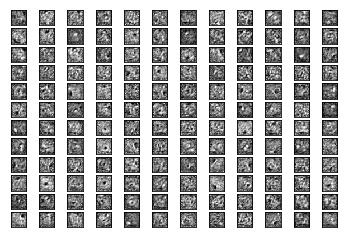

In [0]:

ft_map = sess.run(rbm_model.get_feature_map())
plot_features(ft_map)

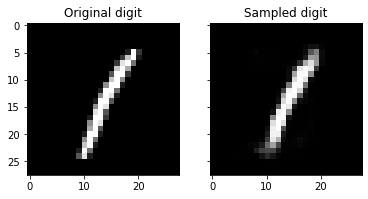

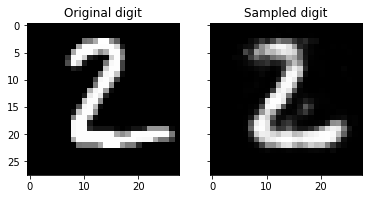

In [0]:
def show_digit(original, fake):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(original.reshape((28,28)),cmap = plt.cm.gray)
    ax1.set_title('Original digit')
    ax2.imshow(fake.reshape((28,28)),cmap = plt.cm.gray)
    ax2.set_title('Sampled digit')
    plt.show()

train_image = mnist.train.images[1] # from train distribution
sample_train = rbm_model.gibbs(1, v=v).eval(session=sess, feed_dict={v: train_image.reshape(1,-1).astype(np.float32)})  
show_digit(original=train_image, fake=sample_train)  

test_image = mnist.test.images[1] # from test distribution
sample_test = rbm_model.gibbs(1, v=v).eval(session=sess, feed_dict={v: test_image.reshape(1,-1).astype(np.float32)})    
show_digit(original=test_image, fake=sample_test)  

tf.reset_default_graph()